In [2]:
import networkx as nx
import numpy as np
import random
random.seed(10)
import scipy.linalg

from walkers import Simulation

In [3]:
def sample_ER(N, p):
    rd = np.random.rand(N,N)
    A = np.triu(rd < (p))
    np.fill_diagonal(A, 0)
    return A
    
def gen_com_graph(N, n_coms, p_high, p_low):
    N_pc = int(N / n_coms)
    A_struct = np.zeros((N,N))
    for i in range(n_coms):
        A_struct[i*N_pc:(i+1)*N_pc, i*N_pc:(i+1)*N_pc] = sample_ER(N_pc, p_high)
    A_random = sample_ER(N, p_low)
    A = A_struct + A_random
    

    return nx.from_numpy_matrix(A), A_struct, A_random

In [4]:
G, _, _ = gen_com_graph(30, 2, 0.3, 0.02)

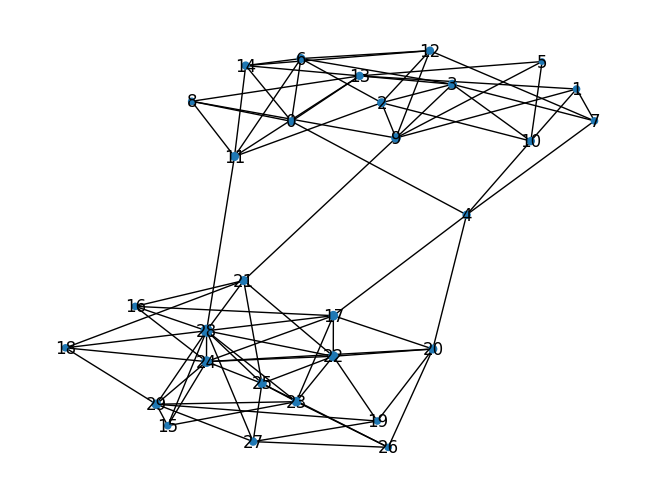

In [5]:
d = dict(G.degree)
nx.draw(G, nodelist=d.keys(), node_size=[v * 5 for v in d.values()], with_labels=True)

In [6]:
# all walkers start at node 10
sim1 = Simulation(10000, G, 0.1, 200, 10)
sim1.run(1.0)

In [7]:
# all walkers start at random nodes (uniformly distributed)
sim2 = Simulation(10000, G, 0.1, 200)
sim2.run()


KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

Text(0, 0.5, 'Fraction of walkers')

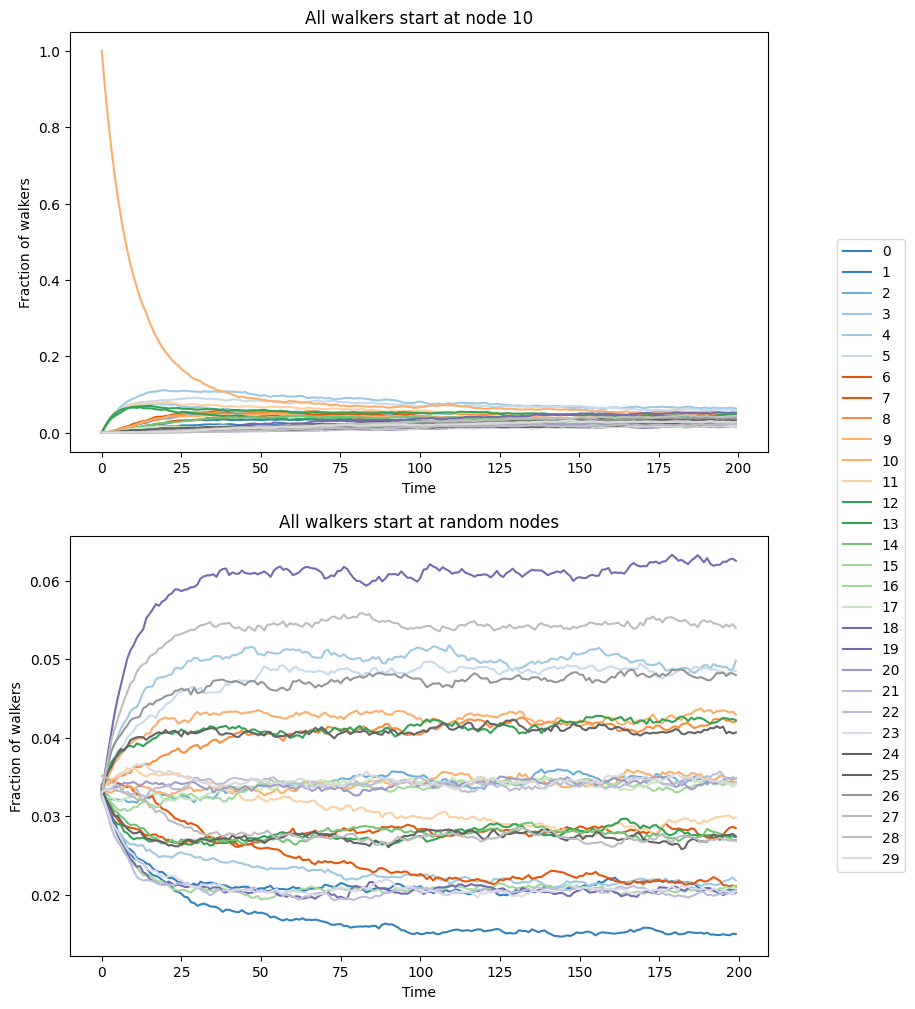

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 12))

jet = cm = plt.get_cmap('tab20c') 
cNorm  = colors.Normalize(vmin=0, vmax=sim2.G.number_of_nodes())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(0, sim1.G.number_of_nodes(), 1):
    color_val = scalarMap.to_rgba(i)
    ax1.plot(sim1.timeline, sim1.node_log[:,i]/sim1.n_walkers, label=i, color=color_val)

ax1.set_title('All walkers start at node 10')
ax1.set_xlabel('Time')
ax1.set_ylabel('Fraction of walkers')

for i in range(0, sim2.G.number_of_nodes(), 1):
    color_val = scalarMap.to_rgba(i)
    ax2.plot(sim2.timeline, sim2.node_log[:,i]/sim2.n_walkers, label=i, color=color_val)

ax1.legend(np.linspace(0, sim1.G.number_of_nodes()-1, sim1.G.number_of_nodes(), dtype=int), loc=(1.1, -1))
ax2.set_title('All walkers start at random nodes')
ax2.set_xlabel('Time')
ax2.set_ylabel('Fraction of walkers')



In [13]:
# computes distribution analytically
def walker_prob(lambda_, G, timeline, p_0):
    degrees = [val for (node, val) in G.degree()]
    D = np.diag(degrees)
    D_inv = np.linalg.inv(D)

    L = nx.laplacian_matrix(G).toarray()

    L_rw = np.matmul(D_inv, L)

    res = np.zeros((G.number_of_nodes(), len(timeline)))

    for i in range(len(timeline)):
        t = timeline[i]
        res[:,i] = np.matmul(p_0, scipy.linalg.expm(-lambda_ * t * L_rw))

    return res

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Text(75.22222222222221, 0.5, 'Fraction of walkers')

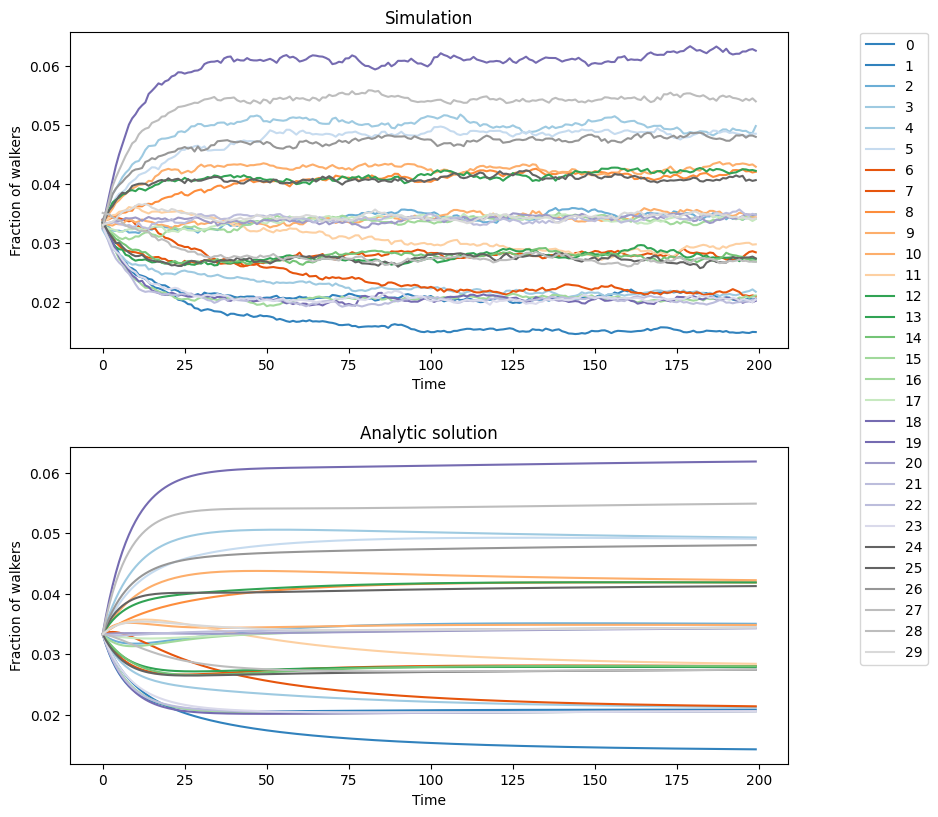

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 9))
fig.tight_layout(pad=5.0)

jet = cm = plt.get_cmap('tab20c') 
cNorm  = colors.Normalize(vmin=0, vmax=sim2.G.number_of_nodes())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(0, sim2.G.number_of_nodes(), 1):
    color_val = scalarMap.to_rgba(i)
    ax1.plot(sim2.timeline, sim2.node_log[:,i]/sim2.n_walkers, label=i, color=color_val)

ax1.set_title('Simulation')
ax1.set_xlabel('Time')
ax1.set_ylabel('Fraction of walkers')

analytic_probs = walker_prob(
    0.1, 
    sim2.G, 
    sim2.timeline,
    np.full(sim2.G.number_of_nodes(), 1/sim2.G.number_of_nodes()))

for i in range(0, sim2.G.number_of_nodes(), 1):
    color_val = scalarMap.to_rgba(i)
    ax2.plot(sim2.timeline, analytic_probs[i,:], label=i, color=color_val)

ax1.legend(np.linspace(0, sim1.G.number_of_nodes()-1, sim1.G.number_of_nodes(), dtype=int), loc=(1.1, -1))
ax2.set_title('Analytic solution')
ax2.set_xlabel('Time')
ax2.set_ylabel('Fraction of walkers')


Text(455.6767676767676, 0.5, 'Time')

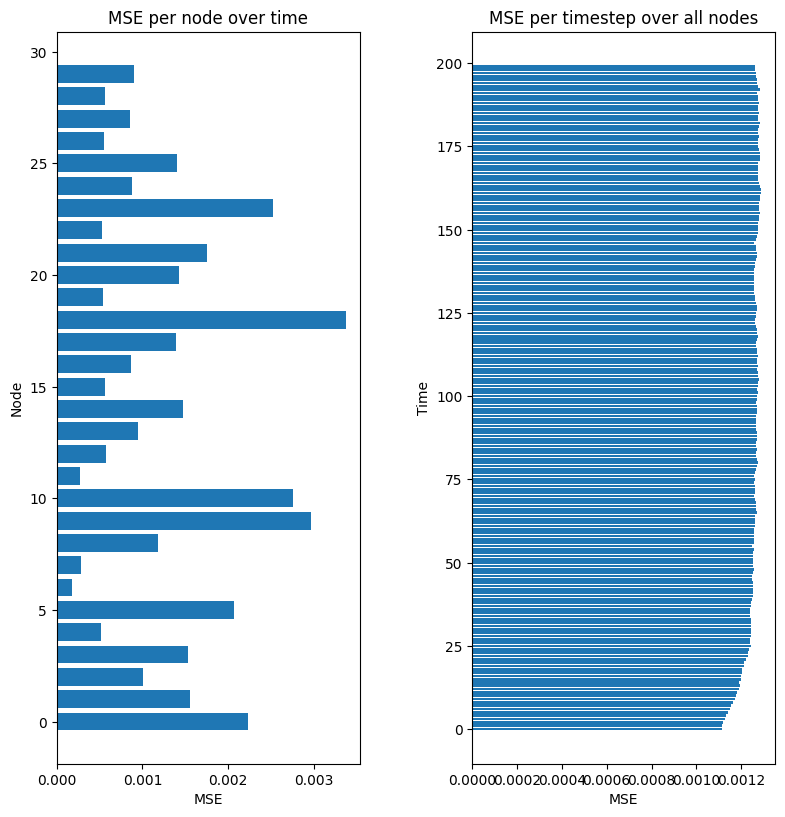

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 9))
fig.tight_layout(pad=5.0)

bars = np.zeros(sim2.G.number_of_nodes())
for i in range(0, sim2.G.number_of_nodes(), 1):
    error = np.average(((sim2.node_log[:,i] - analytic_probs[i,:])/sim2.n_walkers)**2)
    bars[i] = error

y_pos = np.arange(len(bars))
ax1.barh(y_pos, bars, align='center')
ax1.set_title('MSE per node over time')
ax1.set_xlabel('MSE')
ax1.set_ylabel('Node')

bars = np.zeros(len(sim2.timeline))
for i in range(0, len(sim2.timeline), 1):
    #ma_nodes = avg_window(sim2.node_log[i,:], window)
    error = np.average(((sim2.node_log[i,:] - analytic_probs[:,int(sim2.timeline[i])])/sim2.n_walkers)**2)
    bars[i] = error

y_pos = np.arange(len(bars))
ax2.barh(y_pos, bars, align='center')
ax2.set_title('MSE per timestep over all nodes')
ax2.set_xlabel('MSE')
ax2.set_ylabel('Time')


(0.0, 0.01)

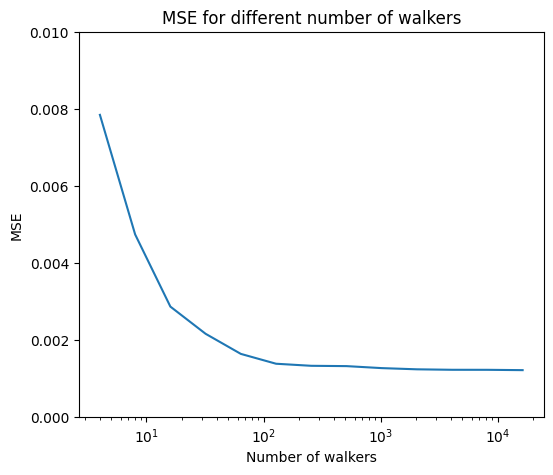

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

mse = np.zeros(13)
se_min = np.zeros(13)
se_max = np.zeros(13)
x = np.zeros(13)
for i in range(2, 15, 1):
    n_walkers = 2**i
    sim = Simulation(n_walkers, G, 0.1, 100)
    # results in 5 checkpoints per simulation
    sim.run(20.0)
    analytic_probs = walker_prob(
        0.1, 
        sim.G, 
        sim.timeline,
        np.full(sim.G.number_of_nodes(), 1/sim.G.number_of_nodes()))

    mse[i-2] = np.average(((sim.node_log - analytic_probs.T)/sim.n_walkers)**2)
    x[i-2] = n_walkers

ax.plot(x, mse)
ax.set_title('MSE for different number of walkers')
ax.set_xlabel('Number of walkers')
ax.set_ylabel('MSE')
ax.set_xscale('log')
ax.set_ylim(0, 0.01)
    